In [1]:
#Determine whether skewness and curtosis are important to map daily historical temp distributions to 
#pre-industrial conditions.

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [2]:
LAT = 50.42
LON = 228.8
savefigs = '/global/scratch/users/harsha/savefigs/Oct20/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc = 'columbia'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [3]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(5)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46305 instead
  warnings.warn(


In [4]:
cluster

In [9]:
%%time
ds_temp = xr.open_mfdataset(cesm2_path+'lens_tmax.zarr',engine='zarr')

CPU times: user 7.71 s, sys: 772 ms, total: 8.48 s
Wall time: 21.4 s


In [10]:
ds_temp

,Array,Chunk
Bytes,1.20 TiB,769.92 MiB
Shape,"(60226, 192, 288, 99)","(3650, 192, 288, 1)"
Count,1684 Tasks,1683 Chunks
Type,float32,numpy.ndarray


In [11]:
%%time
#Check for global warming in CSEM2 model tasmax
ds_mean_nw = ds_temp.sel(time =slice('18500101','18741231')).mean('time').mean('member')
ds_mean_w   = ds_temp.sel(time=slice('19900101','20141231')).mean('time').mean('member')
dsm_w  = ds_mean_w.TREFHTMX
dsm_nw = ds_mean_nw.TREFHTMX

CPU times: user 726 ms, sys: 26 ms, total: 752 ms
Wall time: 725 ms


In [11]:
%%time
#Check for global warming in CSEM2 model tasmax
ds_j30mean_nw = ds_temp.sel(time =slice('18500101','18741231')).mean('time').mean('member')
ds_j30mean_w  = ds_temp.sel(time=slice('19900101','20141231')).mean('time').mean('member')
dsmj30_w      = ds_j30mean_w.TREFHTMX
dsmj30_nw     = ds_j30mean_nw.TREFHTMX
# anomaly = dsm_w - dsm_nw
# anomaly.plot()
# plt.savefig('global_anomaly19502014_18501914.png')
# plt.show()

CPU times: user 715 ms, sys: 33.8 ms, total: 748 ms
Wall time: 712 ms


In [12]:
%%time
#Close to berkeley
tnw = ds_temp.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest')\
.sel(time=slice('18500101','18741231')) 

tw  = ds_temp.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest')\
.sel(time=slice('19900101','20141231'))
#t-temp, nw - no-warming, w-warming
#tw.isel(member=0).plot()
#tnw.isel(member=0).plot()

CPU times: user 89.7 ms, sys: 11.6 ms, total: 101 ms
Wall time: 89.9 ms


In [13]:
%%time
#January 30th
jan30   = np.arange(170)
jan30   = jan30*365 +29
tj30nw  = tnw.isel(time=jan30[:25])
tj30w   = tw.isel(time=jan30[:25])
tnwj30 = tj30nw.stack(mtime=('member','time'),create_index=False)
twj30  = tj30w.stack(mtime=('member','time'),create_index=False)
#twj30.mean().values - tnwj30.mean().values 

CPU times: user 42.4 ms, sys: 10.3 ms, total: 52.8 ms
Wall time: 44.3 ms


In [14]:
%%time
twj30.std().values 

CPU times: user 32.9 s, sys: 2.72 s, total: 35.6 s
Wall time: 44.2 s


array(2.2106478, dtype=float32)

In [102]:
tnwj30

<xarray.DataArray 'TREFHTMX' (mtime: 2475)>
dask.array<reshape, shape=(2475,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 50.42
    lon      float64 228.8
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 1850-01-30 00:00:00 ... 1874-01-30 00:00:00
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [103]:
%%time
tcj30 = (twj30 - twj30.mean())*(tnwj30.std()/twj30.std()) + tnwj30.mean()
#twj30_corr.mean().values - tnwj30.mean().values
tnwj30.to_dataset().to_netcdf(cvals+'tnwj30_loc.nc')
twj30.to_dataset().to_netcdf(cvals+'twj30_loc.nc')
tcj30.to_dataset().to_netcdf(cvals+'tcj30_loc.nc')

CPU times: user 3min 39s, sys: 11 s, total: 3min 50s
Wall time: 4min 8s


In [109]:
%%time
tnwj30 = xr.open_mfdataset(cvals+'tnwj30_loc.nc',engine='netcdf4')
twj30  = xr.open_mfdataset(cvals+'twj30_loc.nc',engine='netcdf4')
tcj30  = xr.open_mfdataset(cvals+'tcj30_loc.nc',engine='netcdf4')
twj30  = twj30.TREFHTMX
tnwj30 = tnwj30.TREFHTMX
tcj30  = tcj30.TREFHTMX

In [162]:
%%time
twaj30 = twj30.mean('mtime')-tnwj30.mean('mtime')
twaj30.values

CPU times: user 568 ms, sys: 48.3 ms, total: 616 ms
Wall time: 619 ms


array(0.12841797, dtype=float32)

In [167]:
twj30.std('mtime').values - tnwj30.std('mtime').values

-0.037404776

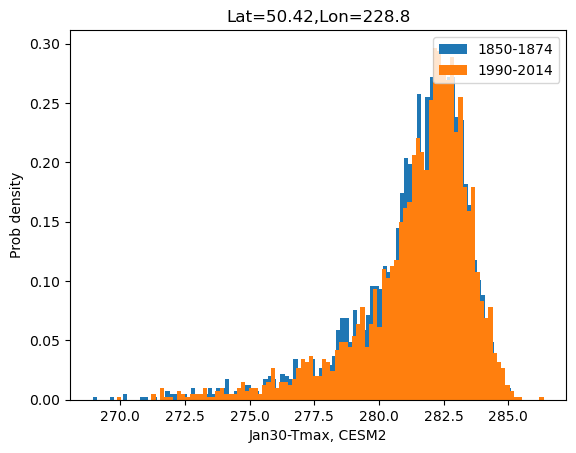

CPU times: user 1min 2s, sys: 3.38 s, total: 1min 5s
Wall time: 1min 10s


In [19]:
%%time
%matplotlib inline
#January 30th
plt.hist(tnwj30,density='True',bins=100,label='1850-1874')
plt.hist(twj30, density='True',bins=100, label='1990-2014')
#plt.hist(twj30_corr, density='True',bins=100, label='1950-2014:Adj')
plt.xlabel('Jan30-Tmax, CESM2')
plt.ylabel('Prob density')
plt.title('Lat='+str(LAT)+',Lon='+str(LON))
plt.legend(loc='upper right')
plt.savefig(savefigs+loc+'_pdf_jan30.png')
plt.show()


In [110]:
%%time
#Compute quantile function - Jan 30 tmax
quants = np.arange(0,1,0.001)
#quants
qnwj30  = tnwj30.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qwj30   = twj30.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qcj30   = tcj30.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

CPU times: user 158 ms, sys: 12.3 ms, total: 170 ms
Wall time: 155 ms


In [111]:
qwaj30= qwj30-qnwj30 
qcaj30= qcj30-qnwj30 #w= warming, a = anomaly

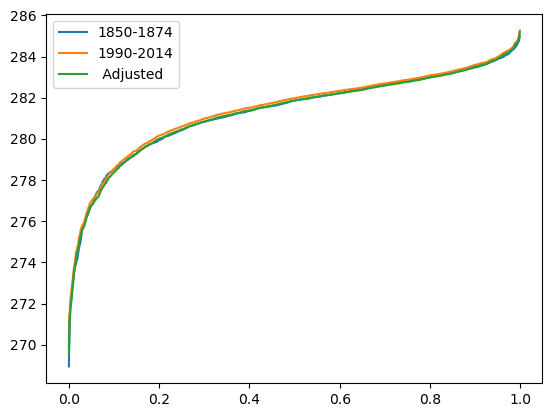

CPU times: user 5.33 s, sys: 472 ms, total: 5.8 s
Wall time: 5.64 s


In [112]:
%%time
%matplotlib inline
plt.plot(quants,qnwj30,label='1850-1874')
plt.plot(quants,qwj30,label='1990-2014')
plt.plot(quants,qcj30,label=' Adjusted')
plt.legend(loc='upper left')
plt.show()


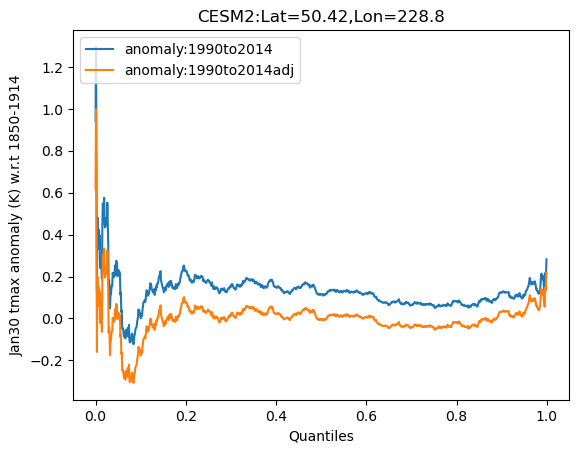

CPU times: user 1min 46s, sys: 5.04 s, total: 1min 51s
Wall time: 2min 5s


In [94]:
%%time
plt.plot(quants,qwj30-qnwj30,label='anomaly:1990to2014')
plt.plot(quants,qcj30-qnwj30,label='anomaly:1990to2014adj')
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel('Jan30 tmax anomaly (K) w.r.t 1850-1914')
plt.xlabel('Quantiles')
plt.show()

In [95]:
#qnwj30 = qnwj30.rename({'quantile':'permilles'})
qwj30  = qwj30.rename({'quantile':'permilles'})
qcj30  = qcj30.rename({'quantile':'permilles'})
qnwj30 = qnwj30.rename({'quantile':'permilles'})

In [24]:
%%time
qwj30.to_dataset().to_zarr(cvals+'qwj30.zarr')
qnwj30.to_dataset().to_zarr(cvals+'qnwj30.zarr')
qcj30.to_dataset().to_zarr(cvals+'qcj30.zarr')

Task exception was never retrieved
future: <Task finished name='Task-734' coro=<Client._gather.<locals>.wait() done, defined at /global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/client.py:2002> exception=AllExit()>
Traceback (most recent call last):
  File "/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/client.py", line 2011, in wait
    raise AllExit()
distributed.client.AllExit

KeyboardInterrupt



In [129]:
%%time
qnwj30  = xr.open_mfdataset(cvals+'qnwj30.zarr',engine='zarr')
qwj30   = xr.open_mfdataset(cvals+'qwj30.zarr',engine='zarr')
qcj30   = xr.open_mfdataset(cvals+'qcj30.zarr',engine='zarr')
qwaj30  = qwj30-qnwj30 
qcaj30  = qcj30-qnwj30 #w= warming, a = anomaly

CPU times: user 562 ms, sys: 36.3 ms, total: 598 ms
Wall time: 565 ms


In [90]:
tnwj30

<xarray.DataArray 'TREFHTMX' (mtime: 2475)>
dask.array<reshape, shape=(2475,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 50.42
    lon      float64 228.8
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 1850-01-30 00:00:00 ... 1874-01-30 00:00:00
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [141]:
%%time
######## Boostrap Confidence Intervals for the quantiles #####
#a = anopmaly, b=bootstrap samples
nboot     = 1000
tnwj30b   = xs.resample_iterations(tnwj30,nboot,'mtime')
twj30b    = xs.resample_iterations(twj30,nboot,'mtime')
tcj30b    = xs.resample_iterations(tcj30,nboot,'mtime')
qnwj30b   = tnwj30b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qwj30b    = twj30b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qcj30b    = tcj30b.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qwaj30b   = qwj30b - qnwj30b
qcaj30b   = qcj30b - qnwj30b

CPU times: user 3min 48s, sys: 16 s, total: 4min 4s
Wall time: 3min 50s


In [142]:
%%time
qwaj30b  = qwaj30b.rename({'quantile':'permilles'})
qcaj30b  = qcaj30b.rename({'quantile':'permilles'})
qwaj30b.to_dataset().to_zarr(cvals+'qwaj30b.zarr')
qcaj30b.to_dataset().to_zarr(cvals+'qcaj30b.zarr')

CPU times: user 2min 32s, sys: 5.21 s, total: 2min 37s
Wall time: 2min 35s


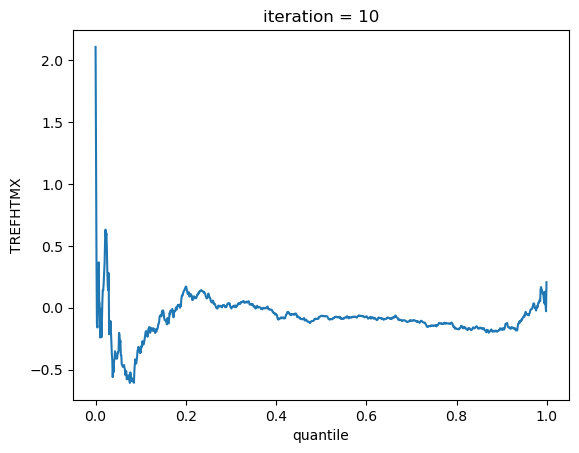

In [132]:
qwaj30b = xr.open_mfdataset(cvals+'qwaj30b.zarr',engine='zarr')
qcaj30b = xr.open_mfdataset(cvals+'qcaj30b.zarr',engine='zarr')
qwaj30b.TREFHTMX.sel(iteration=10).plot()

In [145]:
qwaj30b  = qwaj30b.rename({'quantile':'permilles'})
qcaj30b  = qcaj30b.rename({'quantile':'permilles'})

In [146]:
%%time
qwaj30_cilb = qwaj30b.chunk(dict(iteration=-1)).quantile(0.05,dim='iteration')
qwaj30_ciub = qwaj30b.chunk(dict(iteration=-1)).quantile(0.95,dim='iteration')
qcaj30_cilb = qcaj30b.chunk(dict(iteration=-1)).quantile(0.05,dim='iteration')
qcaj30_ciub = qcaj30b.chunk(dict(iteration=-1)).quantile(0.95,dim='iteration')
#qwaj30

CPU times: user 829 ms, sys: 43.5 ms, total: 872 ms
Wall time: 831 ms


In [149]:
%%time
qwaj30_cilb.to_dataset().to_zarr(cvals+'qwaj30_cilb.zarr',mode='w')
qwaj30_ciub.to_dataset().to_zarr(cvals+'qwaj30_ciub.zarr',mode='w')
qcaj30_cilb.to_dataset().to_zarr(cvals+'qcaj30_cilb.zarr',mode='w')
qcaj30_ciub.to_dataset().to_zarr(cvals+'qcaj30_ciub.zarr',mode='w')

CPU times: user 4min 16s, sys: 8.44 s, total: 4min 25s
Wall time: 4min 23s


In [83]:
qwaj30

<xarray.Dataset>
Dimensions:    (permilles: 1000)
Coordinates:
  * permilles  (permilles) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
Data variables:
    TREFHTMX   (permilles) float64 dask.array<chunksize=(1000,), meta=np.ndarray>

In [6]:
%%time
qnwj30  = xr.open_mfdataset(cvals+'qnwj30.zarr',engine='zarr')
qwj30   = xr.open_mfdataset(cvals+'qwj30.zarr',engine='zarr')
qcj30   = xr.open_mfdataset(cvals+'qcj30.zarr',engine='zarr')
qwaj30  = qwj30-qnwj30 
qcaj30  = qcj30-qnwj30 #w= warming, a = anomaly

CPU times: user 309 ms, sys: 47.2 ms, total: 356 ms
Wall time: 455 ms


In [7]:
%%time
qwaj30_cilb = xr.open_mfdataset(cvals+'qwaj30_cilb.zarr',engine='zarr')
qwaj30_ciub = xr.open_mfdataset(cvals+'qwaj30_ciub.zarr',engine='zarr')
qcaj30_cilb = xr.open_mfdataset(cvals+'qcaj30_cilb.zarr',engine='zarr')
qcaj30_ciub = xr.open_mfdataset(cvals+'qcaj30_ciub.zarr',engine='zarr')
qwaj30_cilb = qwaj30_cilb.TREFHTMX.drop('quantile')
qwaj30_ciub = qwaj30_ciub.TREFHTMX.drop('quantile')
qwaj30      = qwaj30.TREFHTMX
qcaj30_cilb = qcaj30_cilb.TREFHTMX.drop('quantile')
qcaj30_ciub = qcaj30_ciub.TREFHTMX.drop('quantile')
qcaj30      = qcaj30.TREFHTMX
#qcaj30_cilb = qcaj30_cilb.drop('quantile').to_array()
#qcaj30_ciub = qcaj30_ciub.drop('quantile').to_array()

CPU times: user 255 ms, sys: 31.2 ms, total: 287 ms
Wall time: 269 ms


In [9]:
quants = np.arange(0,1,0.001)
yzeros  = np.zeros(1000)

In [ ]:
#%%time
###### Explicity load data before plotting #######
#qwaj30_ciub  = qwaj30_ciub.values
#qwaj30_cilb  = qwaj30_cilb.values
#qwaj30       = qwaj30.values

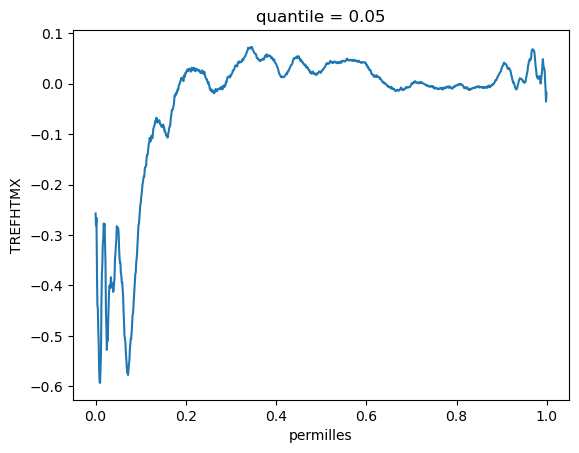

In [148]:
%%time
qwaj30_cilb.plot()

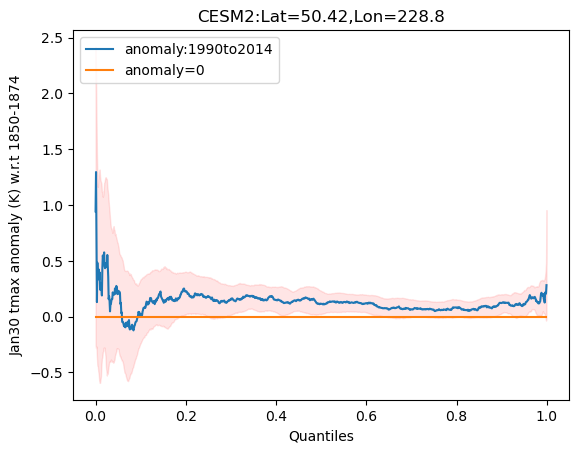

CPU times: user 20.4 s, sys: 2.21 s, total: 22.6 s
Wall time: 34.4 s


In [10]:
%%time
#%matplotlib inline
plt.plot(quants,qwaj30,label='anomaly:1990to2014')
plt.plot(quants,yzeros,label='anomaly=0')
plt.fill_between(quants,qwaj30_cilb,qwaj30_ciub,color='r',alpha=0.1)
#plt.plot(quants,qwaj30_cilb,'--',label='5th percentile')
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel('Jan30 tmax anomaly (K) w.r.t 1850-1874')
plt.xlabel('Quantiles')
plt.show()

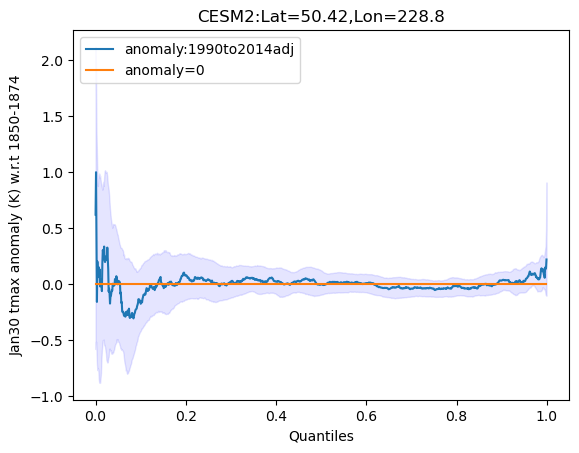

CPU times: user 2.74 s, sys: 355 ms, total: 3.1 s
Wall time: 5.43 s


In [21]:
%%time
#%matplotlib inline
plt.plot(quants,qcaj30,label='anomaly:1990to2014adj')
plt.plot(quants,yzeros,label='anomaly=0')
plt.fill_between(quants,qcaj30_cilb,qcaj30_ciub,color='b',alpha=0.1)
#plt.plot(quants,qwaj30_cilb,'--',label='5th percentile')
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON))
plt.ylabel('Jan30 tmax anomaly (K) w.r.t 1850-1874')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
rmse_qwaj30 = np.sqrt(np.mean(np.square(qwaj30))) #Assuming anomaly =0 is 'true'.
rmse_qcaj30 = np.sqrt(np.mean(np.square(qcaj30)) )
rmse_qwaj30,rmse_qcaj30

In [ ]:
1- (rmse_qcaj30*rmse_qcaj30)/(rmse_qwaj30*rmse_qwaj30)

In [ ]:
mse_qwaj30 = np.mean(np.square(qwaj30))
mse_qcaj30 = np.mean(np.square(qcaj30))
mse_qwaj30, mse_qcaj30

In [ ]:
#mse_qj30gca
mse_qj30gca.sel(lat=LAT,lon=LON,method='nearest').compute()

In [ ]:
mse_qj30gwa.sel(lat=LAT,lon=LON,method='nearest').compute()

In [ ]:
%%time
#Use histogram to compute cdfs- Jan 30
hist_wj30, bins_wj30   = np.histogram(twj30,bins=50,density='True')
hist_nwj30, bins_nwj30 = np.histogram(tnwj30,bins=50,density='True')
hist_cj30, bins_cj30   = np.histogram(twj30_corr,bins=50,density='True')
cdf_wj30               = np.diff(bins_wj30)*np.cumsum(hist_wj30)
cdf_nwj30              = np.diff(bins_nwj30)*np.cumsum(hist_nwj30)
cdf_cj30               = np.diff(bins_cj30)*np.cumsum(hist_cj30)

In [ ]:
%%time
plt.plot(bins_wj30[1:],cdf_wj30,label='1950-2014')
plt.plot(bins_nwj30[1:],cdf_nwj30,label='1850-1914')
plt.plot(bins_cj30[1:],cdf_cj30,label='1950-2014:Adj')
plt.xlabel('Tmax, Jan 30, CESM2')
plt.legend(loc='upper left')
plt.ylabel('CDF')
plt.title('Lat='+str(LAT)+',Lon='+str(LON))
plt.savefig(savefigs+loc+'_cdf_jan30.png')
plt.show()


In [ ]:
twj30_corr.mean().values - tnwj30.mean().values

In [ ]:
################ July 30 Temps #################

In [ ]:
%%time
#July 30 temps
#Compute histograms
jul30    = np.arange(170)
jul30    = jul30*365 + 210 
tjl30nw  = tnw.isel(time=jul30[:65])
tjl30w   = tw.isel(time=jul30[:65])
tnwjl30  = tjl30nw.stack(stacked=[...]) 
twjl30   = tjl30w.stack(stacked=[...])
twjl30_corr = (twjl30 - twjl30.mean())*(tnwjl30.std()/twjl30.std()) + tnwjl30.mean()
twjl30.mean().values - tnwjl30.mean().values

In [ ]:
twjl30.std().values - tnwjl30.std().values

In [ ]:
qnwjl30  = np.quantile(tnwjl30,quants)
qwjl30   = np.quantile(twjl30,quants)
qcjl30   = np.quantile(twjl30_corr,quants)


In [ ]:
%%time
qwajl30= qwjl30-qnwjl30 
qcajl30= qcjl30-qnwjl30 #w= warming, a = anomaly
plt.plot(quants,qwjl30-qnwjl30,label='anomaly:1950to2014')
plt.plot(quants,qcjl30-qnwjl30,label='anomaly:1950to2014adj')
plt.legend(loc='upper left')
plt.ylabel('July 30 tmax anomaly (K) w.r.t 1850-1914')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
rmse_qwajl30 = np.sqrt(np.mean(np.square(qwajl30))) #Assuming anomaly =0 is 'true'.
rmse_qcajl30 = np.sqrt(np.mean(np.square(qcajl30)) )
rmse_qcajl30, rmse_qwajl30

In [ ]:
# %%time
# #Use histogram to compute cdfs
# hist_wjl30, bins_wjl30   = np.histogram(twjl30,bins=50,density='True')
# hist_nwjl30, bins_nwjl30 = np.histogram(tnwjl30,bins=50,density='True')
# hist_cjl30, bins_cjl30   = np.histogram(twjl30_corr,bins=50,density='True')
# cdf_wjl30                = np.diff(bins_wjl30)*np.cumsum(hist_wjl30)
# cdf_nwjl30               = np.diff(bins_nwjl30)*np.cumsum(hist_nwjl30)
# cdf_cjl30                = np.diff(bins_cjl30)*np.cumsum(hist_cjl30)

In [ ]:
%%time
plt.plot(bins_wjl30[1:],cdf_wjl30,label='1950-2014')
plt.plot(bins_nwjl30[1:],cdf_nwjl30,label='1850-1914')
plt.plot(bins_cjl30[1:],cdf_cjl30,label='1950-2014:Adj')
plt.xlabel('Tmax, July 30, CESM2')
plt.legend(loc='upper left')
plt.ylabel('CDF')
plt.title('Lat='+str(LAT)+',Lon='+str(LON))
plt.savefig(savefigs+loc+'_cdf_jul30.png')
plt.show()


In [ ]:
########### RMSE Globe #################
quants = np.arange(0,1,0.01)
tnwg = ds_temp.TREFHTMX.sel(time=slice('18500101','19141231')) 
twg  = ds_temp.TREFHTMX.sel(time=slice('19500101','20141231'))

In [ ]:
#tnwg

In [ ]:
tj30wg   = twg.isel(time=jan30[:65])
#tj30wg

In [ ]:
%%time
#January 30th
jan30    = np.arange(170)
jan30    = jan30*365 +29
tj30nwg  = tnwg.isel(time=jan30[:65])
tj30wg   = twg.isel(time=jan30[:65])
tj30gnw  = tj30nwg.stack(mtime=('member','time'))
tj30gw   = tj30wg.stack(mtime=('member','time'))

In [ ]:
#tj30gw

In [ ]:
tj30gwc = (tj30gw - tj30gw.mean('mtime'))*(tj30gnw.std('mtime')/tj30gw.std('mtime')) + tj30gnw.mean('mtime')
#twj30_corr = (twj30 - twj30.mean())*(tnwj30.std()/twj30.std()) + tnwj30.mean()

In [ ]:
#xr.align(tj30gw,tj30nw,join='exact')

In [ ]:
corr_ano = tj30gwc.mean('mtime') - tj30gnw.mean('mtime')

In [ ]:
#corr_ano.plot()

In [ ]:
corr_sano = tj30gwc.std('mtime') - tj30gnw.std('mtime')

In [ ]:
#corr_sano.plot()

In [ ]:
%time
qj30gnw = tj30gnw.chunk(dict(mtime=-1,lat=1)).quantile(quants,dim='mtime')
qj30gw  = tj30gw.chunk(dict(mtime=-1,lat=1)).quantile(quants,dim='mtime') #g=global
qj30gwc = tj30gwc.chunk(dict(mtime=-1,lat=1)).quantile(quants,dim='mtime') #c=corrected

In [ ]:
%time
qj30gwa    =  qj30gw-qj30gnw
qj30gca    =  qj30gwc-qj30gnw

In [ ]:
#Create Zero dataarray for true value
lats      = qj30gnw['lat'].data
lons      = qj30gnw['lon'].data
temp      = np.zeros((100,lats.size,lons.size,))
quantiles = qj30gnw['quantile'].data
#########################
tv = xr.DataArray(
    data=temp,
    dims=['quantile','lat', "lon"],
    coords=dict(
        lon      =(["lon"], lons),
        lat      =(["lat"], lats),
        quantile =(['quantile'],quantiles),
    ),
    attrs=dict(
        description="2m air temperature.",
        units="degK",
    ),
)
####################
tv = tv.chunk(dict(quantile=100,lat=1,lon=288))

In [ ]:
tv

In [ ]:
rmse_qj30gwa = xs.rmse(qj30gwa,tv,dim='quantile')
rmse_qj30gca = xs.rmse(qj30gca,tv,dim='quantile')

In [ ]:
%time 
rmse_path = '/global/scratch/users/harsha/CESM2/LENS/cvals/rmse' 
rmse_qj30gwa = rmse_qj30gwa.to_dataset()
rmse_qj30gca = rmse_qj30gca.to_dataset()
rmse_qj30gwa.to_zarr(rmse_path+'jan30_rmse_ano1950_2014.zarr')
rmse_rmse_qj30gca.to_zarr(rmse_path+'jan30_rmse_ano1950_2014_adj.zarr')

In [ ]:
%time
thresh =0.4
#vmin = np.min(obs_ano)
#vmax = np.max(obs_ano)
vmin = -5.0
vmax = 5.0
wcolors,wbins = get_colors_list(vmin,vmax,-thresh,thresh,0.2)
wbins = np.arange(vmin,vmax+0.2,0.5)
wcmap = colors.LinearSegmentedColormap.from_list('terrain_map_white', wcolors)


In [ ]:
%time
#levels = np.arange(0,4,0.4)
ax = plt.axes(projection=cart.crs.PlateCarree())
levs = np.arange(0,5,0.5)
#colors= ['v','i','b','g','y','o','c','m','w']
rmse_qj30gwa.plot.contourf(ax=ax,levels =levs,cmap='rainbow',transform=cart.crs.PlateCarree())
ax.coastlines(color="red")
plt.title('RMSEs of tmax anomaly 1950-2014')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()


In [ ]:
mse_qj30gwa = xs.mse(qj30gwa,tv,dim='quantile')
mse_qj30gca = xs.mse(qj30gca,tv,dim='quantile')
#xr.align(mse_qj30gwa,mse_qj30gwa,join='outer')

In [ ]:
gsignal = 1 - (mse_qj30gca/mse_qj30gwa)
gsignal

In [ ]:
%time
msig = gsignal.where(gsignal==gsignal.min(),drop='True').squeeze()

In [ ]:
#gsignal.rename(signal)
%time
lsig = gsignal.where(gsignal<0.1,drop='True').squeeze()

In [ ]:
gsignal.sel(lat=LAT,lon=LON,method='nearest').compute()